In [9]:
# Example of maximum-likelihood fit with iminuit.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / November 2020

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import container
plt.rcParams["font.size"] = 14

In [10]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb

In [11]:
numVal = 200
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

In [12]:
# Function to be minimized is negative log-likelihood
def negLogL(par):
    pdf = f(xData, par)
    return -np.sum(np.log(pdf))

In [43]:
# Initialize Minuit and set up fit:
#     initial parameter values are guesses,
#     error values set initial step size in search algorithm,
#     limit_param to set limits on parameters (needed here to keep pdf>0),
#     fix_param=True to fix a parameter,
#     errordef=0.5 means errors correspond to logL = logLmax - 0.5,
#     pedantic=False to turn off verbose messages.

par     = np.array([theta, mu, sigma, xi])      # initial values (here equal true values)
parname = ['theta', 'mu', 'sigma', 'xi']
parstep = np.array([0.1, 1., 1., 1.])           # initial setp sizes
parfix  = [False, True, False, False]            # change these to fix/free parameters
parlim  = [(0.,1), (None, None), (0., None), (0., None)]
m = Minuit.from_array_func(negLogL, par, parstep, name=parname,
    limit=parlim, fix=parfix, errordef=0.5, pedantic=False)

In [44]:
# do the fit, get errors, extract results
m.migrad()                                             # minimize -logL
MLE = m.np_values()                                    # max-likelihood estimates
sigmaMLE = m.np_errors()                               # standard deviations
cov = m.np_matrix(skip_fixed=True)                     # covariance matrix
rho = m.np_matrix(skip_fixed=True, correlation=True)   # correlation coeffs.
npar = len(m.np_values())
nfreepar = len(cov[0])

In [45]:
npar = len(m.np_values())
print(r'par index, name, estimate, standard deviation:')
for i in range(npar):
    if not(m.is_fixed(i)):
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r'free par indices, covariance, correlation coeff.:')
for i in range(nfreepar):
    for j in range(nfreepar):
        print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta       =  0.211986  +/-  0.064456
   2 sigma       =  2.100195  +/-  0.495499
   3 xi          =  5.049386  +/-  0.707743

free par indices, covariance, correlation coeff.:
0 0 0.004190 1.000000
0 1 0.017494 0.544629
0 2 -0.029251 -0.638398
1 0 0.017494 0.544629
1 1 0.246269 1.000000
1 2 -0.141023 -0.401443
2 0 -0.029251 -0.638398
2 1 -0.141023 -0.401443
2 2 0.501096 1.000000


<ipython-input-45-32e75441021e>:4: DeprecationWarning: `is_fixed` is deprecated: Use `this_object.fixed[arg]` instead
  if not(m.is_fixed(i)):


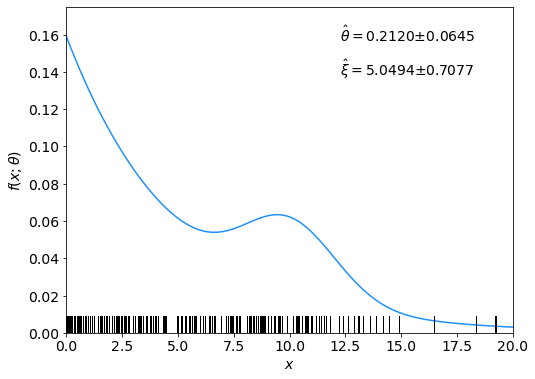

In [46]:
# Plot fitted pdf
yMin = 0.
yMax = f(0., MLE)*1.1
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, MLE)
plt.plot(xCurve, yCurve, color='dodgerblue')

# Plot data as tick marks
tick_height = 0.05*(yMax - yMin)
xvals = [xData, xData]
yvals = [np.zeros_like(xData), tick_height * np.ones_like(xData)]
plt.plot(xvals, yvals, color='black', linewidth=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x; \theta)$')
plt.figtext(0.6, 0.8, r'$\hat{\theta} = $' + f'{MLE[0]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[0]:.4f}')
plt.figtext(0.6, 0.72, r'$\hat{\xi} = $' + f'{MLE[3]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[3]:.4f}')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()

In [ ]:
# Make scan of lnL (for theta, if free)
if not(m.is_fixed('theta')):
    plt.figure()
    m.draw_mnprofile('theta')

<ipython-input-47-12afaa9b81d8>:2: DeprecationWarning: `is_fixed` is deprecated: Use `this_object.fixed[arg]` instead
  if not(m.is_fixed('theta')):


In [ ]:
# Make a contour plot of lnL = lnLmax - 1/2 (here for theta and xi)
if not(m.is_fixed('theta') | m.is_fixed('xi')):
    plt.figure()
    m.draw_mncontour('theta', 'xi', nsigma=1, numpoints=200);
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.figtext(0.6, 0.8, r'$\ln L = \ln L_{\rm max} - 1/2$')
    plt.show()

In [ ]:
# Confidence region from lnL = lnLmax - Q/2 (here for theta and xi)
if not(m.is_fixed('theta') | m.is_fixed('xi')):
    CL = 0.95
    Q = chi2.ppf(CL, nfreepar)   # lnL = lnLmax - Q/2
    sig = np.sqrt(Q)             # number of sigmas of contour
    fig, ax = plt.subplots(1,1)
    contour = m.mncontour('theta', 'xi', sigma=sig, numpoints=200)[2]
    contour.append(contour[0])    # close the contour
    con = np.array(contour)
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.plot(con[:,0], con[:,1], color='black', linewidth=1, label=r'95%')
    plt.xlabel(r'$\theta$', labelpad=10)
    plt.ylabel(r'$\xi$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.show()